<a href="https://colab.research.google.com/github/spegas/Dacon/blob/main/stock_price_predict_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy pandas matplotlib scikit-learn tensorflow yfinance

In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam

In [ ]:
# 주식 데이터 가져오기
ticker = '005930.KS'  # 삼성전자 종목코드 예시

In [ ]:
end_date = datetime.today()
str_end_date = end_date.strftime('%Y-%m-%d')
print(" -- str_end_date -- ")
print(str_end_date)

start_date = end_date - timedelta(days=1000)

str_start_date = start_date.strftime('%Y-%m-%d')
print(" -- str_start_date -- ")
print(str_start_date)

 -- str_end_date -- 
2024-05-23
 -- str_start_date -- 
2021-08-27


In [ ]:
from copy import deepcopy
fetch_stock_data = yf.download(ticker, start=str_start_date, end=str_end_date)
print(fetch_stock_data.columns)
print(fetch_stock_data.head(5))
# stock_data = fetch_stock_data[['Close', 'Volume']]

stock_data = fetch_stock_data.copy(deep=True).drop(columns=['Adj Close'])

[*********************100%%**********************]  1 of 1 completed

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
               Open     High      Low    Close     Adj Close    Volume
Date                                                                  
2021-08-27  74300.0  75000.0  73800.0  74300.0  70375.078125  15172748
2021-08-30  75400.0  75500.0  74200.0  74600.0  70659.218750  12686999
2021-08-31  74900.0  76700.0  74300.0  76700.0  72648.281250  24630370
2021-09-01  76700.0  77100.0  75900.0  76800.0  72743.015625  16114775
2021-09-02  76800.0  76800.0  75700.0  76000.0  71985.265625  15347486


In [ ]:
# 추가 데이터 (유사 종목 및 회사 회계정보)
# 유사 종목 데이터 예시
similar_ticker = '000660.KS'  # SK하이닉스 종목코드 예시

In [ ]:
fetch_similar_data = yf.download(similar_ticker, start=str_start_date, end=str_end_date)
# stock_data['Similar_Close'] = fetch_similar_data['Close']

similar_stock_data = fetch_similar_data.copy(deep=True).drop(columns=['Adj Close'])

[*********************100%%**********************]  1 of 1 completed


In [ ]:
total_stock_data = pd.concat([stock_data, similar_stock_data], axis=1)

In [ ]:
# 회사 회계 정보 예시 (여기서는 임의의 데이터 사용)
# 실제로는 회사의 분기별 또는 연간 재무제표 데이터를 사용
financial_data = {
    'Date': stock_data.index,
    'Revenue': np.random.uniform(100, 500, len(stock_data)),
    'Operating_Income': np.random.uniform(10, 50, len(stock_data))
}

In [ ]:
# financial_df = pd.DataFrame(financial_data)
# financial_df.set_index('Date', inplace=True)

# # 주식 데이터와 재무 데이터 병합
# ml_input_data = pd.concat([total_stock_data, financial_df], axis=1)
ml_input_data = total_stock_data.copy()

In [ ]:
# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(ml_input_data)

In [ ]:
# 학습 데이터와 테스트 데이터 분리
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

print(train_data.shape, test_data.shape)

(535, 10) (134, 10)


In [ ]:
# 데이터셋 생성 함수
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step)])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

In [ ]:
# time_step -> LSTM 학습에 사용되는 날짜, 30일이면 약 한달치 데이터를 학해해서 그 다음날꺼 예측 하는 것임
# 만약, 이시간을 길게하면 X_test, Y_test데이터가 안 만들어 질 수 있고
# 이를 극복하기 위해서 yahoo에서 주식 데이터 수집 날짜 간격을 늘리거나, 학습에 사용되는 날짜 즉, time_step를 짧게 하면 됨.
time_step = 60

# my_epochs는 학습을 몇번 반복 할것인가를 의미하는 것임,
my_epochs=5

In [ ]:
X_train, Y_train = create_dataset(train_data, time_step)
print(X_train.shape, Y_train.shape)

X_test, Y_test = create_dataset(test_data, time_step)
print(X_test.shape, Y_test.shape)

(474, 60, 10) (474,)
(73, 60, 10) (73,)


In [ ]:
# LSTM 모델 입력 형식에 맞게 데이터 변형
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

# LSTM 모델 정의 및 학습
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25, activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(1))

# 옵티마이저 설정 (학습률 변경)
my_optimizer = Adam(learning_rate=0.0005)  # 학습률 설정

model.compile(optimizer=my_optimizer, loss='mean_squared_error')
model.fit(X_train, Y_train, batch_size=1, epochs=my_epochs)

Epoch 1/5
474/474 [==============================] - 24s 39ms/step - loss: 0.0083
Epoch 2/5
474/474 [==============================] - 22s 46ms/step - loss: 0.0033
Epoch 3/5
474/474 [==============================] - 18s 39ms/step - loss: 0.0029
Epoch 4/5
474/474 [==============================] - 20s 42ms/step - loss: 0.0024
Epoch 5/5
474/474 [==============================] - 18s 39ms/step - loss: 0.0025


In [ ]:
# 테스트 데이터 예측
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 예측값 역정규화
train_predict = scaler.inverse_transform(np.concatenate((train_predict, np.zeros((train_predict.shape[0], scaled_data.shape[1] - 1))), axis=1))[:,0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], scaled_data.shape[1] - 1))), axis=1))[:,0]

3/3 [==============================] - 0s 20ms/step


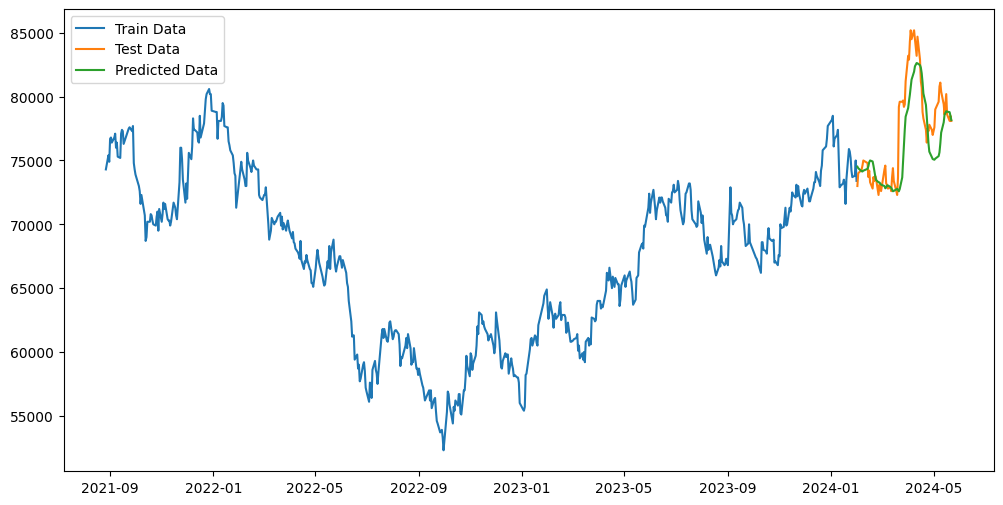

In [ ]:
# 실제값과 예측값 시각화
plt.figure(figsize=(12, 6))
plt.plot(ml_input_data.index[:train_size + time_step + 1], scaler.inverse_transform(scaled_data[:train_size + time_step + 1])[:,0], label='Train Data')
plt.plot(ml_input_data.index[train_size + time_step + 1:], scaler.inverse_transform(scaled_data[train_size + time_step + 1:])[:,0], label='Test Data')
plt.plot(ml_input_data.index[train_size + time_step + 1:], test_predict, label='Predicted Data')
plt.legend()
plt.show()

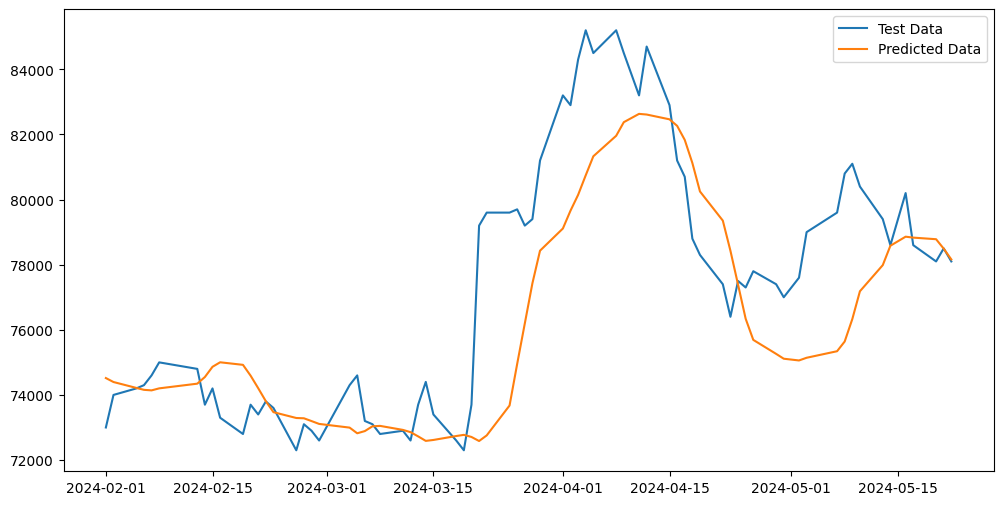

In [ ]:
# 실제값과 예측값 시각화
plt.figure(figsize=(12, 6))
plt.plot(ml_input_data.index[train_size + time_step + 1:], scaler.inverse_transform(scaled_data[train_size + time_step + 1:])[:,0], label='Test Data')
plt.plot(ml_input_data.index[train_size + time_step + 1:], test_predict, label='Predicted Data')
plt.legend()
plt.show()